# **Import các thư viện :**

In [1]:
!pip install --upgrade tensorflow==2.16.1
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

In [2]:
#Import các thư viện xử lý ảnh :
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tifffile as tiff
from glob import glob
import seaborn as sns 
import albumentations as albu
from skimage.io import imread
from tqdm import tqdm
import gc


#Tensorflow Imports :
import tensorflow as tf
import tensorflow.keras as k
import keras
from tensorflow import reduce_sum
from tensorflow.keras.utils import Sequence , normalize , img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Layer,
                                    Conv2DTranspose, MaxPool2D, MaxPooling2D, Dropout,
                                    Flatten, Activation, Concatenate, UpSampling2D,
                                    BatchNormalization , MaxPooling2D,
                                    Add, Multiply, Lambda, GlobalAveragePooling2D, 
                                    GlobalMaxPooling2D, Reshape, Dense, LeakyReLU)

from tensorflow.keras.losses import binary_crossentropy
from keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import AdamW, RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
from keras.callbacks import CSVLogger


#Sklearn Import :
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_score

# **Xây dựng các hàm Loss và Metrics :**

In [3]:
def Dice_Coef(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return ((2. * intersection + smooth) / (union + smooth))

def Dice_Loss(y_true, y_pred):
    return 1 - Dice_Coef(y_true, y_pred)

# **Tiến hành xây dựng các hàm đọc và xử lý dữ liệu ảnh :**

In [4]:
def load_data(img_height, img_width, path):
    IMAGES_PATH = path + '/images/'
    MASKS_PATH = path + '/masks/'

    ids = glob(IMAGES_PATH + "*.jpg")

    num_images = len(ids)
    X = np.zeros((num_images, img_height, img_width, 3), dtype=np.float32)
    Y = np.zeros((num_images, img_height, img_width), dtype=np.float32)

    for n, id_ in tqdm(enumerate(ids), total=num_images):
        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        #Resize image
        pillow_image = Image.fromarray(image)
        pillow_image = pillow_image.resize((img_width, img_height))
        image = np.array(pillow_image)

        X[n] = image / 255.0  #Normalize image

        #Resize mask
        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_width, img_height), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        if mask_.ndim == 3 and mask_.shape[2] > 1:
            mask = (np.mean(mask_, axis=-1) >= 127).astype(np.float32)
        else:
            mask = (mask_ >= 127).astype(np.float32)

        Y[n] = mask

    Y = np.expand_dims(Y, axis=-1)

    return X, Y

#Defining the augmentations :
aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images(x_train, y_train):
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        aug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(aug['image'])  
        y_train_out.append(aug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [5]:
test = 0.15
seed = 42
img_size = 256

#Load Data : 
X, Y = load_data(img_size, img_size, '/kaggle/input/kvasir-segmentation/Kvasir-SEG')
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test, shuffle= True, random_state = seed)

100%|██████████| 1000/1000 [00:32<00:00, 30.55it/s]


# **Load mô hình :**

In [6]:
model = tf.keras.models.load_model(
    '/kaggle/input/retrain-dcgc-deep-net-weight/Retrain_DCGC_Deep_Net_v1.keras', 
    custom_objects={'Dice_Coef': Dice_Coef, 'Dice_Loss' : Dice_Loss}
)
model.summary()

Model: "DCGC_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │          6 │ input_layer[0][0] │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │         96 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │          8 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │         36 │ activation_1[0][… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 256, 256,  │      9,216 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │          8 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │         16 │ activation_2[0][… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │         24 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │        256 │ activation_5[0][… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │         24 │ input_layer[0][0

 Total params: 54,890,824 (209.39 MB)

 Trainable params: 27,422,763 (104.61 MB)

 Non-trainable params: 45,296 (176.94 KB)

 Optimizer params: 27,422,765 (104.61 MB)

# **Compile cho model :**

In [7]:
#Tạo optimizer:
EPOCHS = 600
learning_rate = 1e-4

#Tạo optimizer :
optimizer = RMSprop(learning_rate = learning_rate
                 )

#Compile mô hình :
model.compile(loss=Dice_Loss,
              optimizer=optimizer,
              metrics=[Dice_Coef])

# **Tiến hành training mô hình :**

In [8]:
model_path = 'Retrain_DCGC_Deep_Net_v2.keras'

In [9]:
step = 0
min_loss_for_saving = 0.1
metric = -1
epoch_save_weight = -1
for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch+1}/{EPOCHS}')
    print('='*50)
            
    image_augmented, mask_augmented = augment_images(x_train, y_train)
        
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=8, 
              validation_data=None, verbose=1)
    
    prediction = model.predict(x_test, batch_size=8, verbose=0)
    loss = Dice_Loss(y_test, prediction)
    
    loss = loss.numpy()
    metric_t = (1 - loss) * 100 
    print(f"Metric Test : {metric_t:.4f}%")
    print("Loss Test : " + str(loss))
    print('='*50)

    if min_loss_for_saving > loss:
        min_loss_for_saving = loss
        epoch_save_weight = epoch+1
        metric = (1 - min_loss_for_saving) * 100
        print("Saved model with min loss: ", loss)
        model.save(model_path)
        print('='*50)
    
    if epoch_save_weight > 0 :
        print(f'Save model from epoch {epoch_save_weight} with metric {metric:.4f}%')
        print('='*50)

    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 1/600


I0000 00:00:1724089323.835667      79 service.cc:145] XLA service 0x7b388c006450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724089323.835727      79 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1724089425.452566      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - dice__coef: 0.9114 - loss: 0.0886
Metric Test : 91.2837%
Loss Test : 0.08716297
Saved model with min loss:  0.08716297
Save model from epoch 1 with metric 91.2837%
Training, epoch 2/600
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - dice__coef: 0.9168 - loss: 0.0833
Metric Test : 90.7284%
Loss Test : 0.09271604
Save model from epoch 1 with metric 91.2837%
Training, epoch 3/600
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - dice__coef: 0.9108 - loss: 0.0892
Metric Test : 90.6101%
Loss Test : 0.09389907
Save model from epoch 1 with metric 91.2837%
Training, epoch 4/600
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - dice__coef: 0.9097 - loss: 0.0903
Metric Test : 90.9987%
Loss Test : 0.09001309
Save model from epoch 1 with metric 91.2837%
Training, epoch 5/600
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms/step - dice__coef: 0.9187 - loss: 0.0812
Metric Test : 90.0710%
Loss Test : 0.09928995
Save model from epoch 1 with metric 91.2837%
Training, epoch 6/60

# **Phân đoạn ảnh dựa trên mô hình đã training :**

In [10]:
#Reload the best model :
path = '/kaggle/working/' + model_path

model = tf.keras.models.load_model(
    path, custom_objects={'Dice_Coef': Dice_Coef, 'Dice_Loss' : Dice_Loss}
)

In [11]:
print("Prediction")
print("=" *50)
y_pred = model.predict(x_test, batch_size=8, verbose=0)
y_pred_b = (y_pred >= 0.5).astype(np.float32)

Prediction


**Hiển thị kết quả phân đoạn (Dice Coeficent, Jacard, Accuracy) :**

In [12]:
dice_scores = []
jaccard_scores = []
accuracy_scores = []
y_true = y_true_thr = y_test

for i in range(len(y_test)) :
    
    flattened_labels = K.flatten(y_true_thr[i])
    flattened_predictions = K.flatten(y_pred_b[i])
    
    #Tính Dice Coefficient và Jaccard Index :
    dice_scores.append(Dice_Coef(y_true[i], y_pred[i]))
    jaccard_scores.append(jaccard_score(flattened_labels, flattened_predictions))

    #Tính Accuracy :
    accuracy_scores.append(accuracy_score(flattened_labels, flattened_predictions))

#In ra kết quả :
print(f"Dice Coefficient Mean: {np.mean(dice_scores)*100}%")
print(f"Jaccard Index Mean: {np.mean(jaccard_scores)*100}%")
print(f"Accuracy Mean: {np.mean(accuracy_scores)*100}%")

Dice Coefficient Mean: 91.7524516582489%
Jaccard Index Mean: 86.77473329016064%
Accuracy Mean: 97.7344462076823%


**Trực quan hoá metric :**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


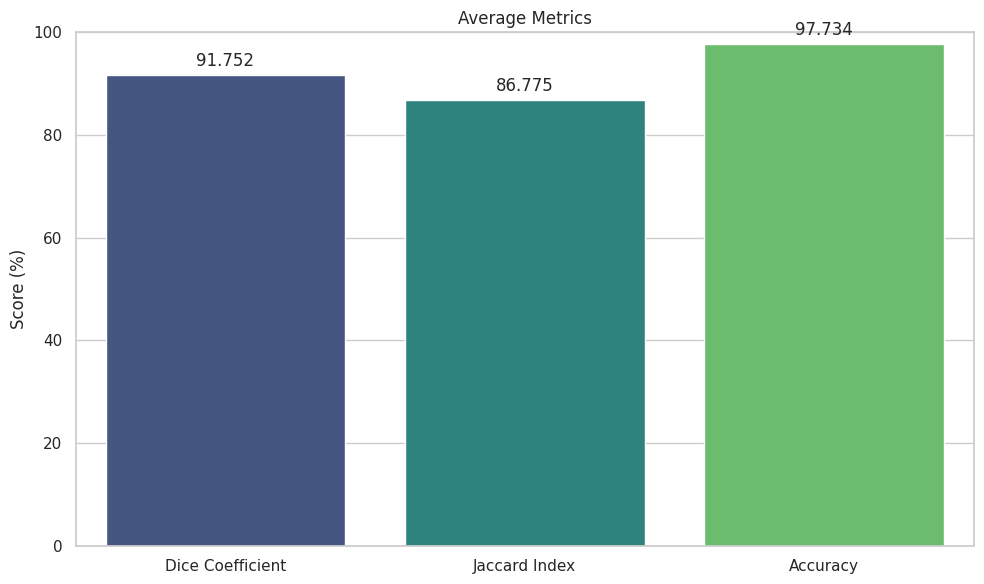

In [13]:
#Tính means :
mean_dice = np.mean(dice_scores) * 100
mean_jaccard = np.mean(jaccard_scores) * 100
mean_accuracy = np.mean(accuracy_scores) * 100

#Dữ liệu trực quan :
metrics = ['Dice Coefficient', 'Jaccard Index', 'Accuracy']
values = [mean_dice, mean_jaccard, mean_accuracy]

#Tạo biểu đồ cột :
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=metrics, y=values, palette="viridis")

#Thêm giá trị của các metric lên cột :
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

#Thiết lập labels và title :
ax.set(ylim=(0, 100))
plt.ylabel('Score (%)')
plt.title('Average Metrics')

#Hiển thị biểu đồ :
plt.tight_layout()
plt.show()

# **Hiển thị ảnh đã phân đoạn :**

In [14]:
def Show_Images_Mask_Pred(x_test, y_true, binary_predictions, qual=10):
    top_qual = np.argsort(dice_scores)[-qual:]
    
    for i in top_qual :
        plt.figure(figsize=(15, 5))

        #Hệ số Dice Coef, Jaccard, Accuracy :
        print(f'Accuracy For Image {i}: {accuracy_scores[i]}')
        print(f'Dice Coefficent For Image {i}: {dice_scores[i]}')
        print(f'Jaccard For Image {i}: {jaccard_scores[i]}')

        plt.subplot(1, 4, 1)
        plt.imshow(x_test[i][...,::-1])
        plt.title('Ảnh Thật')
        plt.axis('off')  # Bỏ grid

        plt.subplot(1, 4, 2)
        plt.imshow(y_true[i], cmap='gray')
        plt.title('Mặt Nạ Thật')
        plt.axis('off')  # Bỏ grid

            
        plt.subplot(1, 4, 3)
        plt.imshow(y_pred[i], cmap='gray')
        plt.title('Dự Đoán Chưa Áp Ngưỡng')
        plt.axis('off')  # Bỏ grid

    
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred_b[i], cmap='gray')
        plt.title('Dự Đoán Đã Áp Ngưỡng')
        plt.axis('off')  # Bỏ grid

        plt.show()
        print('='*80)

Accuracy For Image 60: 0.997711181640625
Dice Coefficent For Image 60: 0.9870948791503906
Jaccard For Image 60: 0.9742665980442614


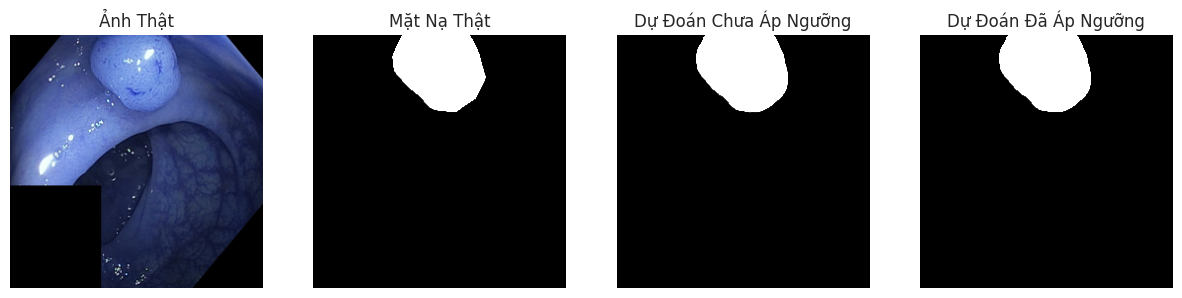

Accuracy For Image 106: 0.990509033203125
Dice Coefficent For Image 106: 0.9871307611465454
Jaccard For Image 106: 0.9746226030191758


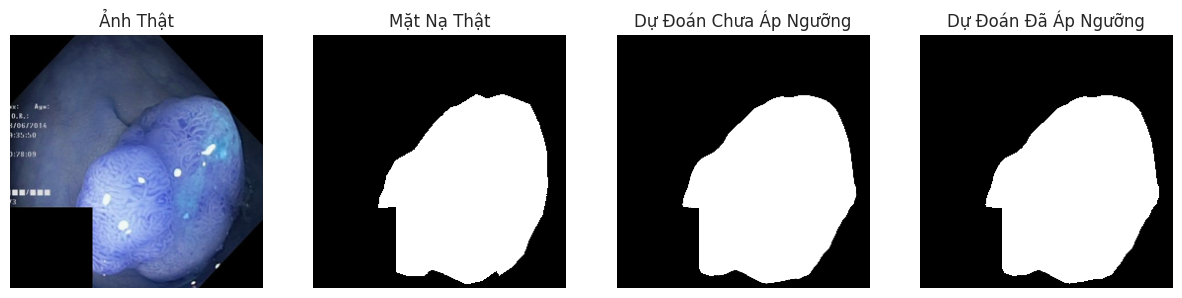

Accuracy For Image 56: 0.9923248291015625
Dice Coefficent For Image 56: 0.9875460267066956
Jaccard For Image 56: 0.9753528028224225


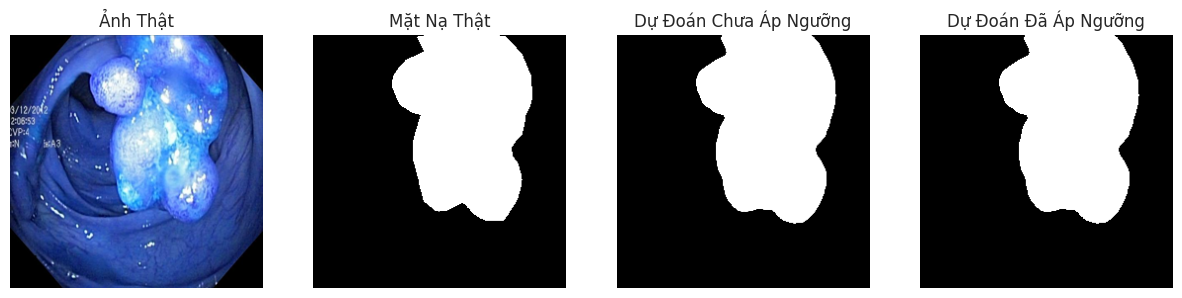

Accuracy For Image 97: 0.9907989501953125
Dice Coefficent For Image 97: 0.9887605309486389
Jaccard For Image 97: 0.9779548861185244


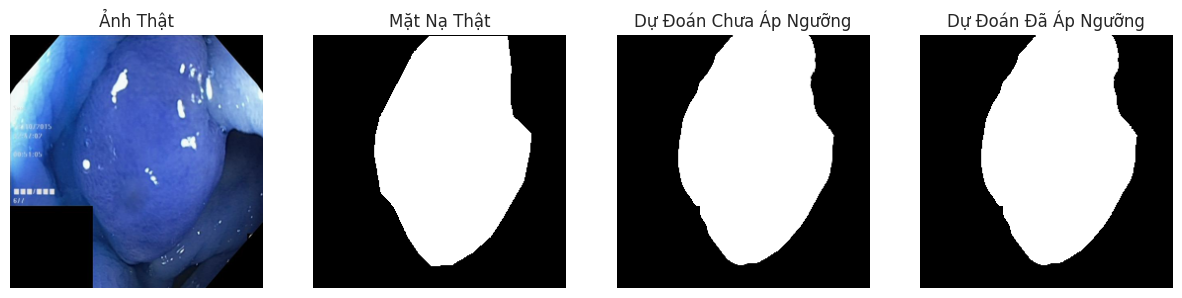

Accuracy For Image 83: 0.9977874755859375
Dice Coefficent For Image 83: 0.9888615608215332
Jaccard For Image 83: 0.97810659821833


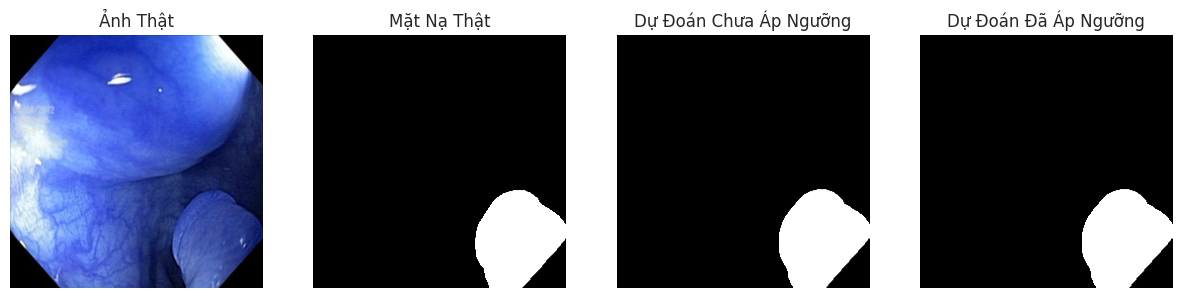

Accuracy For Image 0: 0.9976348876953125
Dice Coefficent For Image 0: 0.9894428253173828
Jaccard For Image 0: 0.9790823211875843


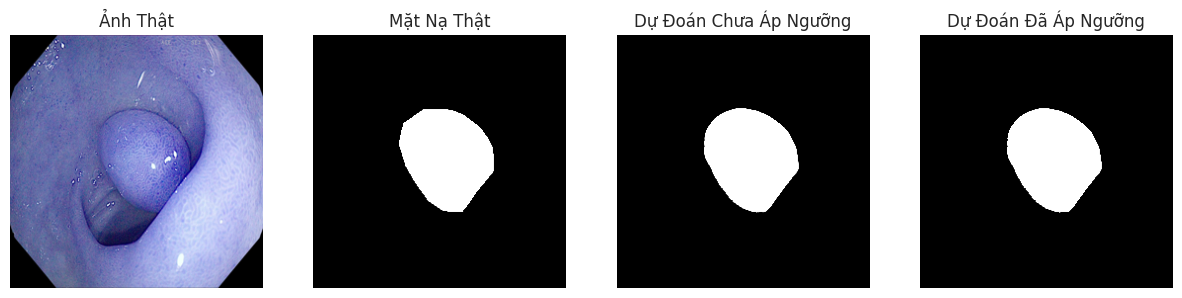

Accuracy For Image 111: 0.998138427734375
Dice Coefficent For Image 111: 0.9904161095619202
Jaccard For Image 111: 0.9809136420525657


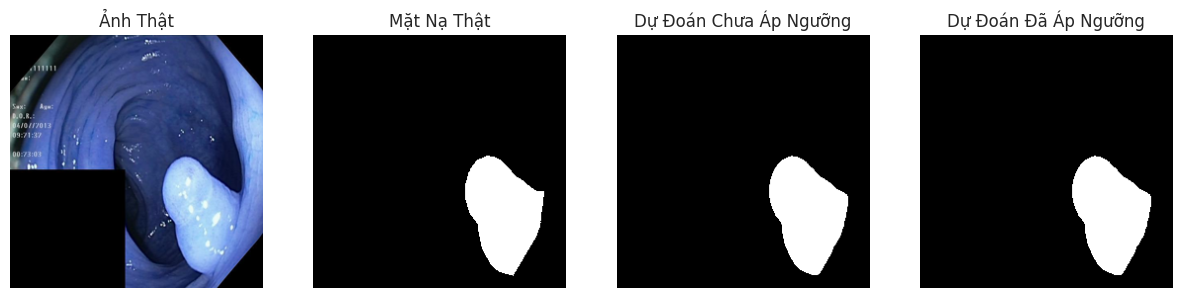

Accuracy For Image 33: 0.996490478515625
Dice Coefficent For Image 33: 0.9904375672340393
Jaccard For Image 33: 0.9813493350632501


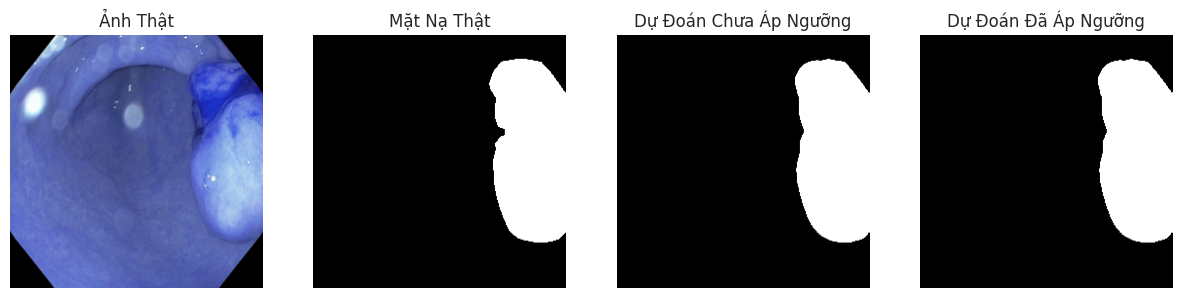

Accuracy For Image 43: 0.9925689697265625
Dice Coefficent For Image 43: 0.9912160634994507
Jaccard For Image 43: 0.9825903549851642


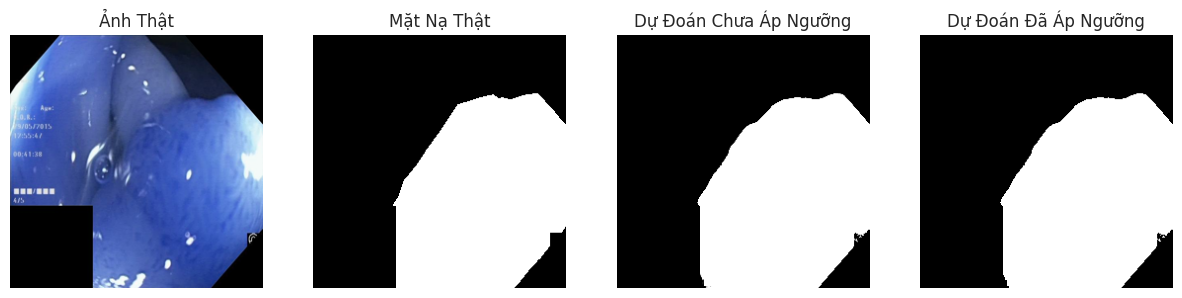

Accuracy For Image 22: 0.9905853271484375
Dice Coefficent For Image 22: 0.9933276176452637
Jaccard For Image 22: 0.9866801951556495


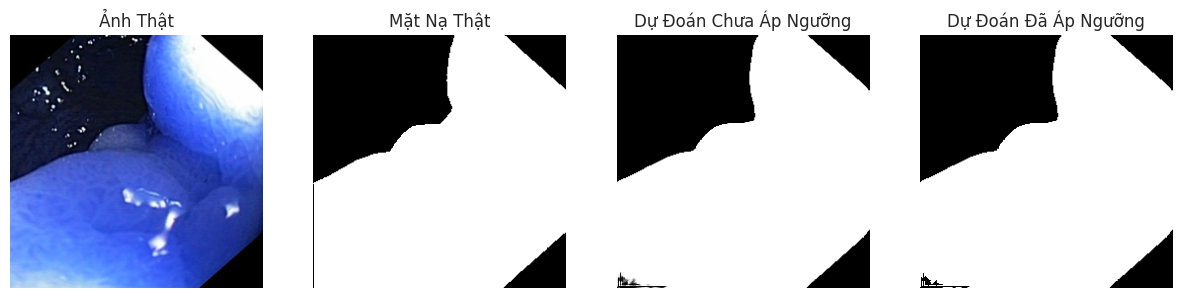

In [15]:
Show_Images_Mask_Pred(x_test , y_test, 
                      y_pred_b, 
                      qual = 10)